In [ ]:
!pip install tellurium &> /dev/null #installing the module into your local Colab environment
!pip install lmfit &> /dev/null
import tellurium as te              #importing the module for this particular notebook

import numpy as np
import matplotlib.pyplot as plt
import lmfit
from lmfit import minimize, Parameters
import pandas as pd
from scipy.optimize import shgo, dual_annealing, differential_evolution, least_squares
%matplotlib inline


PInh_cis <-> PInh_trans  cis->trans by blue light, trans -> cis by uv light. Here, in most cases Trans is a stronger inhibitor (smaller Ki) than Cis. Trans is always a thermal state

Experimental conditions:
Flowrate = 1200 uL/h, reactor volume = 200 uL.
AMC flowrate in the T-junction = 200 uL/h. Sampling time = 15s.
Delay between reactor and detection ~ 5 min.

Km = 85 uM, kcat = 128 1/s


$PI\_trans\xrightarrow{k\_trans\_cis}PI\_cis$

$PI\_cis\xrightarrow{k\_cis\_trans}PI\_trans$



In [ ]:
model_string = '''
model ultransesitivity
   // Reactions:
   R1: PInh_cis  -> PInh_trans; k_blue * blue_light * PInh_cis - k_UV * uv_light * PInh_trans;
   R2: Sub -> AMC; V;

   F1: -> PInh_cis; k_flow* (PInh_cis_inflow - PInh_cis);
   F2: -> PInh_trans; k_flow* (PInh_trans_inflow - PInh_trans);
   F3: -> Sub; k_flow*(Sub_inflow - Sub);
   F4: -> AMC; - k_flow*AMC;

   // Species initializations:
   PInh_cis = 0; PInh_trans =0; Sub=0; AMC=0;
   PInh_cis_inflow=0; PInh_trans_inflow=0; Sub_inflow=0; 
   Cr0=0;

   // Enzymatic rate
   V:=k_cat*Cr0 * (Sub/KM_Sub) / (1 + Sub/KM_Sub + PInh_cis/Ki_cis + PInh_trans/Ki_trans);

   // Rate constants:
   k_blue = 1e1;  k_UV = 1e1;
   KM_Sub = 85e-6; #  uM
   k_cat = 1e3;   # 1
   Ki_cis = 200e-6; Ki_trans = 12e-6;
   k_flow = 0.1;
   blue_light = 0; uv_light = 0;
   
end'''
        
model = te.loada(model_string)
model_amc = te.loada(model_string)

In [ ]:
def reset_model_update_parameters(model, parameters):
  '''First, resets all concentrations and rate constants to the default values specified in the model string.
  Then updates concentrations and rate constants according to the values provided in parameters.
  Parameters:
  model(ExtendedRoadRunner): model constructed with the tellurium package.
  parameters (dict): {parameter: value}'''
  model.resetAll()
  for compound, concentration in parameters.items():
    model[compound] = concentration

In [ ]:
def generate_light_sequence(time_start = 60, time_after_last_pulse = 60, light_sequence = ['uv', 'blue'], time_sequence = [1, 1]):
  '''
  Returns:
  light_pulses_df (DataFrame)'''
  
  #Creates boolean sequncec of uv and blue light. 
  #Boolean 0 is appended in the begining and in the end, 
  #indicating that there is no irradiation before and after the pulses.
  uv_sequence = [0] + [int(condition == 'uv') for condition in light_sequence] + [0]
  blue_sequence = [0] + [int(condition == 'blue') for condition in light_sequence] + [0]

  time_profile = [time_start] + time_sequence + [time_after_last_pulse]
  
  light_pulses_df = pd.DataFrame(data= np.transpose([time_profile, uv_sequence, blue_sequence]), columns = ['time',  'uv_light', 'blue_light'])
  return light_pulses_df

In [ ]:
def simulate_several_pulses(model, light_pulses_df):
  '''function'''
  #model.resetAll()
  time_start = 0
  time_end = 0
  total_result = []
  for idx in light_pulses_df.index:
    pulse_duration  = light_pulses_df.loc[idx,'time']
    #get light conditions
    model['uv_light'] = float(light_pulses_df.loc[idx,'uv_light'])
    model['blue_light'] = float(light_pulses_df.loc[idx,'blue_light'])
    
    time_end += float(pulse_duration)
    result = model.simulate(time_start,time_end,100)
    time_start += float(pulse_duration)

    result_df = pd.DataFrame(data=result.view(), columns = result.colnames)  
    total_result.append(result_df)
  total_result_df = pd.concat(total_result)
  total_result_df = total_result_df.set_index('time')
  return total_result_df



In [ ]:
  #Resample the dataframe to the experimentally used sampling time (15s = 15/60 min)
  resampling_interval= 1
  resampled_time = np.linspace(result.index[0],result.index[-1], 
                               int((result.index[-1] - result.index[0])/resampling_interval + 1))
  resampled_df = pd.DataFrame(index = resampled_time )

In [ ]:
def get_fluorescence(result, Substrate = 40e-6):
  #amc = pd.DataFrame(index = result.index, columns = ['[AMC]'])
  time_counter = 0
  amc_output = []

  resampling_interval= 1
  resampled_time = np.linspace(result.index[0],result.index[-1], 300)
                               #int((result.index[-1] - result.index[0])/resampling_interval))
  resampled_df = pd.DataFrame(index = resampled_time )

  for column in result.columns:
    resampled_df[column] = np.interp(resampled_time, result.index, result[column].values)
  for time, concentrations in resampled_df.iterrows():
    #if time - time_counter >=0:
      conc_dict = concentrations.to_dict()
      reset_model(model_amc, conc_dict)
      model_amc['k_flow'] = 1
      model_amc['Cr0'] = 10*model['Cr0']
      model_amc['Sub'] = Substrate
      model_amc['Sub_inflow'] = Substrate

      reaction_with_amc = model_amc.simulate(0,2,3)

      amc_conc = reaction_with_amc['[AMC]'][-1]
      amc_output.append(amc_conc)
      #amc['time'] = time
      #amc.loc[time, '[AMC]'] = amc_conc
      #time_counter += 60/60
  #resampled_time = np.linspace(result.index[0],result.index[-1], 600)
  #resampled_amc = np.interp(resampled_time, list(result.index), amc_output)
  amc = pd.DataFrame(index = resampled_time, data = amc_output,columns = ['[AMC]'])
      #amc = amc.dropna()
  return amc

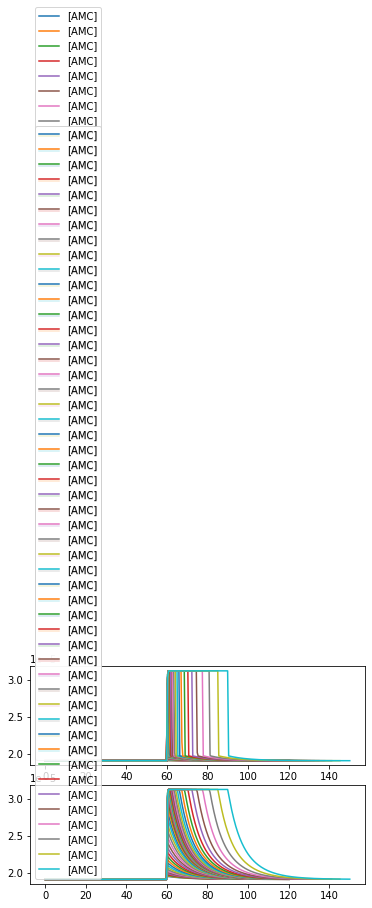

In [ ]:
parameters = {'Cr0': 40e-9, 'PInh_trans_inflow': 200e-6, 'Sub_inflow': 0, 'PInh_trans': 200e-6, 'Sub': 0, 'k_flow' : 0.1}

time_range = np.logspace(np.log10(0.005), np.log10(30),50)
amc_max_uv_blue = np.zeros_like(time_range)
amc_max_uv = np.zeros_like(time_range)

ax1=plt.subplot(2, 1,1)
ax2=plt.subplot(2, 1,2)

for i, time_point in enumerate(time_range):
  reset_model(model, parameters)
  light_pulses_df = generate_light_sequence(light_sequence = ['uv', 'blue'], time_sequence = [time_point, 15/60])
  result = simulate_several_pulses(model, light_pulses_df)
  #result.plot(y='[AMC]', ax=ax1, label='{:.2f}'.format(time_point))
  amc = get_fluorescence(result)
  amc.plot(ax=ax1)
  amc_max_uv_blue[i] = amc['[AMC]'].max()

  reset_model(model, parameters)
  light_pulses_df = generate_light_sequence(light_sequence = ['uv', 'off'], time_sequence = [time_point, 15/60])
  result = simulate_several_pulses(model, light_pulses_df)
  #result.plot(y='[AMC]', ax=ax2, label='{:.2f}'.format(time_point))
  amc = get_fluorescence(result)
  amc.plot(ax=ax2)
  amc_max_uv[i] = amc['[AMC]'].max()


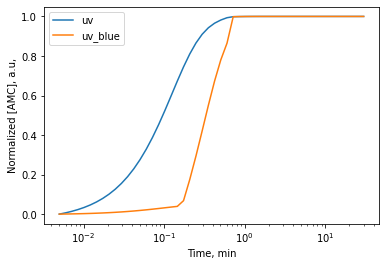

In [ ]:
def norm(data):
  subtracted_data = data - min(data)
  norm_data = subtracted_data / max(subtracted_data)
  return norm_data

plt.figure()
plt.semilogx(time_range, norm(amc_max_uv), label='uv')
plt.semilogx(time_range, norm(amc_max_uv_blue), label='uv_blue')
plt.xlabel('Time, min')
plt.ylabel('Normalized [AMC], a.u,')
plt.legend()
plt.savefig('model_output.png')

In [ ]:
amc_max_uv.transpose()

array([1.94807879e-05, 1.95560580e-05, 1.96457038e-05, 1.97524040e-05,
       1.98793033e-05, 2.00300764e-05, 2.02087889e-05, 2.04207764e-05,
       2.06713357e-05, 2.09669390e-05, 2.13141910e-05, 2.17204767e-05,
       2.21930460e-05, 2.27382395e-05, 2.33605629e-05, 2.40613682e-05,
       2.48364169e-05, 2.56732402e-05, 2.65493999e-05, 2.74319738e-05,
       2.82801498e-05, 2.90507446e-05, 2.97077342e-05, 3.02310248e-05,
       3.06199069e-05, 3.08934553e-05, 3.10823048e-05, 3.12207292e-05,
       3.12815907e-05, 3.12894201e-05, 3.12937500e-05, 3.12958155e-05,
       3.12966418e-05, 3.12969934e-05, 3.12969938e-05, 3.12969948e-05,
       3.12969949e-05, 3.12969952e-05, 3.12969952e-05, 3.12969952e-05,
       3.12969951e-05, 3.12969951e-05, 3.12969951e-05, 3.12969952e-05,
       3.12969951e-05, 3.12969951e-05, 3.12969951e-05, 3.12969951e-05,
       3.12969951e-05, 3.12969952e-05])

In [ ]:
output_data = pd.DataFrame (index = time_range, data = np.array([norm(amc_max_uv), norm(amc_max_uv_blue)]).transpose(), columns = ['uv_pulses','uv_blue_pulses'])
output_data.to_excel('model_output.xlsx')